<a href="https://colab.research.google.com/github/dangdinhtai0001/graph-playground/blob/master/GA_in_shortest_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install networkx deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import networkx as nx
import random
import numpy as np
import pandas as pd

# Số đỉnh của đồ thị
n = 10

start_node=1 
end_node=5

# Xác suất kết nối giữa các cặp đỉnh
p = 0.2

# Tạo đồ thị ngẫu nhiên
G = nx.fast_gnp_random_graph(n, p, directed=True)

while not nx.is_strongly_connected(G):
  G = nx.fast_gnp_random_graph(n, p, directed=True)

# Gán trọng số ngẫu nhiên cho các cạnh
weights = {(u, v): random.randint(1, 10) for u, v in G.edges()}
nx.set_edge_attributes(G, values=weights, name='weight')

# Tạo ma trận kề và chuyển sang pandas DataFrame
matrix = nx.to_numpy_array(G, weight='weight')
df = pd.DataFrame(matrix, index=G.nodes(), columns=G.nodes())

# In DataFrame
print(df)




     0    1    2    3    4    5    6    7     8     9
0  0.0  1.0  6.0  8.0  0.0  0.0  0.0  0.0   4.0   0.0
1  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0
2  2.0  0.0  0.0  0.0  0.0  4.0  0.0  8.0   0.0   0.0
3  0.0  0.0  2.0  0.0  0.0  5.0  9.0  0.0   0.0   0.0
4  9.0  0.0  0.0  0.0  0.0  0.0  0.0  7.0   0.0   5.0
5  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  10.0  10.0
6  0.0  0.0  0.0  0.0  2.0  3.0  0.0  5.0   5.0   0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   9.0   4.0
8  5.0  2.0  0.0  0.0  9.0  0.0  0.0  0.0   0.0   0.0
9  0.0  0.0  0.0  0.0  9.0  0.0  0.0  6.0   0.0   0.0


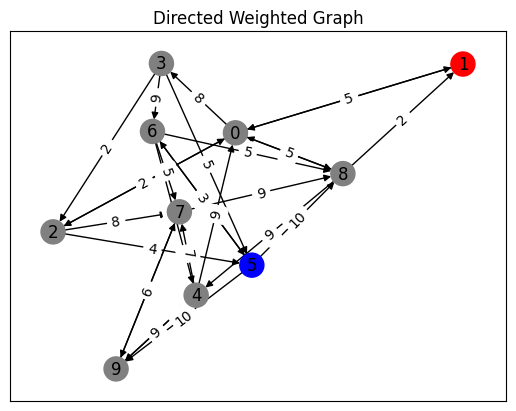

In [26]:
import matplotlib.pyplot as plt

# Vẽ đồ thị
pos = nx.spring_layout(G)
node_color = ['red' if n == start_node else 'blue' if n == end_node else 'gray' for n in G.nodes()]
nx.draw_networkx(G, pos, node_color=node_color)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Directed Weighted Graph")
plt.show()


In [27]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx

# Hàm tạo một cá thể ngẫu nhiên
def create_individual(graph, start, end):
    individual = creator.Individual([start])
    current_node = start

    while current_node != end:
        neighbors = list(graph.neighbors(current_node))
        current_node = random.choice(neighbors)
        individual.append(current_node)

    return individual

# Hàm tính độ dài đường đi
def path_length(graph, individual):
  length = 0
  for i in range(1, len(individual)):
      if graph.has_edge(individual[i - 1], individual[i]):
          length += graph[individual[i - 1]][individual[i]]['weight']
      else:
          return float('inf')  # Trả về độ dài vô cùng nếu cạnh không tồn tại
  return length

# Hàm đánh giá độ thích nghi (fitness)
def eval_fitness(individual, graph):
    return path_length(graph, individual),

# Hàm lai ghép (crossover)
def mate(ind1, ind2):
  for i in range(1, len(ind1) - 1):
      if ind1[i] in ind2:
          j = ind2.index(ind1[i])
          ind1[i + 1:], ind2[j + 1:] = ind2[j + 1:], ind1[i + 1:]
          break

  if ind1[0] != start_node or ind1[-1] != end_node:
      ind1 = create_individual(G, start_node, end_node)
  if ind2[0] != start_node or ind2[-1] != end_node:
      ind2 = create_individual(G, start_node, end_node)

  return ind1, ind2


# Hàm đột biến (mutation)
def mutate(individual):
  if len(individual) < 3:
      return individual,
  index = random.randint(1, len(individual) - 2)
  current_node = individual[index]

  index = random.randint(1, len(individual) - 2)
  current_node = individual[index]

  neighbors = list(G.neighbors(current_node))
  next_node = random.choice(neighbors)
  individual[index + 1] = next_node

  if individual[0] != start_node or individual[-1] != end_node:
      individual = create_individual(G, start_node, end_node)

  return individual,



In [28]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("individual", create_individual, graph=G, start=start_node, end=end_node)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_fitness, graph=G)
toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

population_size = 100
crossover_prob = 0.8
mutation_prob = 0.2
num_generations = 100

population = toolbox.population(n=population_size)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("size", len)


hall_of_fame = tools.HallOfFame(1)

population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=num_generations, stats=stats, halloffame=hall_of_fame, verbose=True)



/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen	nevals	min	max	avg   	std    	size
0  	100   	15 	365	103.81	86.5393	100 
1  	74    	15 	inf	inf   	nan    	100 
2  	90    	15 	inf	inf   	nan    	100 
3  	85    	15 	inf	inf   	nan    	100 
4  	79    	15 	inf	inf   	nan    	100 
5  	86    	15 	inf	inf   	nan    	100 
6  	79    	15 	inf	inf   	nan    	100 
7  	84    	15 	inf	inf   	nan    	100 
8  	87    	15 	inf	inf   	nan    	100 
9  	80    	15 	inf	inf   	nan    	100 
10 	83    	15 	inf	inf   	nan    	100 
11 	91    	15 	inf	inf   	nan    	100 
12 	87    	15 	inf	inf   	nan    	100 
13 	79    	15 	inf	inf   	nan    	100 
14 	85    	15 	inf	inf   	nan    	100 
15 	94    	15 	inf	inf   	nan    	100 
16 	91    	15 	inf	inf   	nan    	100 
17 	89    	15 	inf	inf   	nan    	100 
18 	84    	15 	inf	inf   	nan    	100 
19 	87    	15 	inf	inf   	nan    	100 
20 	77    	15 	inf	inf   	nan    	100 
21 	85    	15 	inf	inf   	nan    	100 
22 	83    	15 	inf	inf   	nan    	100 
23 	87    	15 	inf	inf   	nan    	100 
24 	84    	15 	inf	inf   

In [29]:
best_individual = hall_of_fame[0]
best_fitness = best_individual.fitness.values[0]

print(best_individual)
print(f"Đường đi ngắn nhất: {' -> '.join(map(str, best_individual))}")
print(f"Độ dài đường đi ngắn nhất: {best_fitness}")


[1, 0, 2, 5]
Đường đi ngắn nhất: 1 -> 0 -> 2 -> 5
Độ dài đường đi ngắn nhất: 15.0


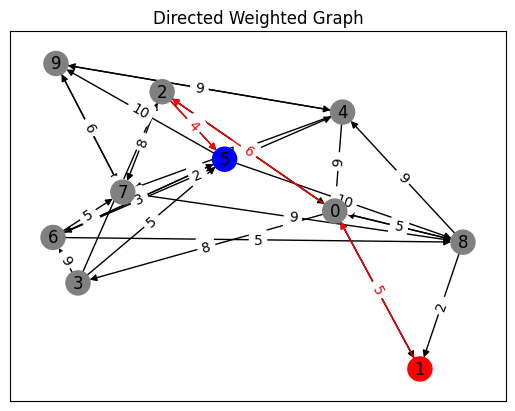

In [30]:
# Tạo list các cạnh trong đường đi
edge_list = [(best_individual[i], best_individual[i+1]) for i in range(len(best_individual)-1)]
# Tạo list các cạnh trong đường đi
edge_list = [(best_individual[i], best_individual[i+1]) for i in range(len(best_individual)-1)] if best_individual else None


# Vẽ đồ thị
pos = nx.spring_layout(G)
node_color = ['red' if n == start_node else 'blue' if n == end_node else 'gray' for n in G.nodes()]
nx.draw_networkx(G, pos, node_color=node_color)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Vẽ cạnh trong đường đi với màu khác
if edge_list:
    edge_colors = ['r' if e in edge_list else 'black' for e in G.edges()]
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='r')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): labels[(u, v)] for (u, v) in edge_list}, font_color='r')
else:
    edge_colors = 'black'
    
plt.title("Directed Weighted Graph")
plt.show()